# Notebook 6
## March 4 2024

# Measuring similarity between strings: Jaquard similarity

Suppose you have several documents and you want to determine how similar they are. One simple, but effective way is to break them into fragments of a given size (usually around 8) and see how many are the same. This works better then simpler methods like counting the number of matches (Hamming distance) as it works under insertion and deletion, and is easier to work with than edit distance (minimum number of insertions, deletions, changes of a character) which is harder to compute.

We start by computing all fragments of a string and store them in a set:

In [1]:
def fragments(string,fragSize):
    F=set()
    for i in range(len(string)-fragSize):
        F.add(string[i:i+fragSize])
    return F

print(fragments("Suppose you have several documents and you want to detemine how similar they are.",5))

{' you ', 's and', 'docum', 'Suppo', ' have', 'nd yo', 'ant t', ' how ', 'ral d', 'nts a', 'and y', 'ou ha', 'y are', 'detem', 'se yo', 'hey a', 'ose y', 'milar', 'to de', 'ey ar', 'etemi', 't to ', 'u hav', 'ave s', 'l doc', 'you w', 'nt to', 'ments', 'uppos', 'evera', ' want', 'have ', ' docu', ' seve', 'veral', 'u wan', 'ine h', ' simi', 'd you', 'ents ', 'want ', 'simil', 'sever', 'emine', 'ppose', 'e you', 'pose ', 'eral ', 'they ', ' dete', 'al do', 'ne ho', 'e how', 'how s', 'r the', 'o det', ' to d', 'lar t', 'ar th', 'ou wa', 'ow si', 'cumen', 'imila', 'mine ', 'ocume', ' and ', 'ts an', ' they', 'w sim', 'ilar ', 'ument', 'temin', 've se', 'you h', 'e sev'}


Then we can compute the Jaquard similarity between two strings, which is simply the percentage of their total fragments that they have in common:

In [2]:
def jaquard(fragments1,fragments2):
    return len(fragments1 & fragments2)/len(fragments1 | fragments2)

In [60]:
S1="Suppose you have several documents and you want to detemine how similar they are."
S2="There are several similar documents that you want to know their similarity."
S3="Thus you can get a value, accurate to within 1% additive error"
F1,F2,F3= (fragments(S,5) for S in (S1,S2,S3))

In [4]:
print(jaquard(F1,F2))
print(jaquard(F1,F3))
print(jaquard(F2,F3))

0.23684210526315788
0.007633587786259542
0.00819672131147541


We will want to have the fragments of many strings, so here is a function that creates a dictionary that maps strings to their set of fragments.

In [5]:
import itertools

# This returns a dictionary that maps strings to their set of fragments
def fragmentDict(strings,fragSize):
    Fragments={}
    for s in strings: 
        Fragments[s]=fragments(s,fragSize)
    return Fragments

fragmentDict([S1,S2,S3],5)

{'Suppose you have several documents and you want to detemine how similar they are.': {' and ',
  ' dete',
  ' docu',
  ' have',
  ' how ',
  ' seve',
  ' simi',
  ' they',
  ' to d',
  ' want',
  ' you ',
  'Suppo',
  'al do',
  'and y',
  'ant t',
  'ar th',
  'ave s',
  'cumen',
  'd you',
  'detem',
  'docum',
  'e how',
  'e sev',
  'e you',
  'emine',
  'ents ',
  'eral ',
  'etemi',
  'evera',
  'ey ar',
  'have ',
  'hey a',
  'how s',
  'ilar ',
  'imila',
  'ine h',
  'l doc',
  'lar t',
  'ments',
  'milar',
  'mine ',
  'nd yo',
  'ne ho',
  'nt to',
  'nts a',
  'o det',
  'ocume',
  'ose y',
  'ou ha',
  'ou wa',
  'ow si',
  'pose ',
  'ppose',
  'r the',
  'ral d',
  's and',
  'se yo',
  'sever',
  'simil',
  't to ',
  'temin',
  'they ',
  'to de',
  'ts an',
  'u hav',
  'u wan',
  'ument',
  'uppos',
  've se',
  'veral',
  'w sim',
  'want ',
  'y are',
  'you h',
  'you w'},
 'There are several similar documents that you want to know their similarity.': {' are ',

If you have several strings and want to find all pairs that are similar you can do this with a double loop. Alas, while this is simple, it is computationally expensive. Given $n$ strings of length $d$, this is going to cost $O(n^2d)$. You could vary the question and say you have $n$ reference documents, and then you have $m$ query documents, and you want for each query document to find the closest reference document, or perhaps all reference documents with similarity below a certain threshold. This would cost $O(nmd)$, which is not feasible for large data sets.

Here is some (slow) code that will return all pairs of strings with distance above some threshold. It returns the pair of the first two strings, which are similar.

In [6]:
def findSimilarStringPairs(Fragments,threshold):
    similarPairs=[]
    for s1,s2 in itertools.combinations(Fragments.keys(),2):
            j=jaquard(Fragments[s1],Fragments[s2])
            if j>=threshold:
                similarPairs.append((j,s1,s2))
    return similarPairs  
            
print(findSimilarStringPairs(fragmentDict([S1,S2,S3],5),0.1))
                

[(0.23684210526315788, 'Suppose you have several documents and you want to detemine how similar they are.', 'There are several similar documents that you want to know their similarity.')]


# minHash

We will now show a clever method to replace a document with a single number, so that the expected value of two documents having the same number is exactly their Jaquard similarity. We call this number the *score* of the document.

Given several documents, take all fragments they generate (duplicates appear only once) and randomly permute them. Then the score of a document is the index of its first fragment of that appears in the permutation

The score does not make sense for a single string in isolation (why?). Here is code that given a list of strings, returns a dictionary that makes the strings to their scores.

In [28]:
import random

# Returns a dictionary that maps strings to a single minHash score
def scoreDict(fragmentDict):
    Scores={}
    allFragments=list(set().union(*fragmentDict.values()))
    random.shuffle(allFragments)
    for s,fragment in fragmentDict.items():
        for i in range(len(allFragments)):
            if allFragments[i] in fragment:
                Scores[s]=i
                break
    return(Scores)

In [72]:
# TRY RUNNING THIS A FEW TIMES AND WATCH THE SCORES CHANGE
ManyScores=scoreDict(fragmentDict([S1,S2,S3],5))
for string,score in ManyScores.items():
    print(score,string)

0 Suppose you have several documents and you want to detemine how similar they are.
0 There are several similar documents that you want to know their similarity.
3 Thus you can get a value, accurate to within 1% additive error


Let $j(x,y)$ be the Jaquard similarity and let $s(x,y)$ be 1 if $x$ and $y$ have the same score and 0 otherwise.

What is nice is that $E[s(x,y)]=j(x,y)$.

Here is the proof. There are three types of fragments:

- Case 1: Those that are present in $x$ and $y$
- Case 2: Those that are absent in $x$ and $y$
- Case 3: Those that are in either $x$ or $y$ but not both.

Let $t_1,t_2,t_3$ be the numbers of these types of fragments. What is $j(x,y)$. It is $\frac{t_1}{t_1+t_3}$.
Now, to determine if the score of two strings is the same, you can view this as a process where we pick random fragments until we find one that is either case 1 or 3. The two strings are then given the same score if we are in case 1, else they have different scores. This happens with chance $\frac{t_1}{t_1+t_3}$.


But remember that the score is always either 0 or 1. Thus, while it has the right expected value, on it own it has little use. As we have done before, the solution is to compute the score several times and take the average. Let's compute $k$ scores $s_1(x,y), \ldots s_k(x,y)$ and define $\hat{f}(x,y)=\frac{1}{k}\sum_{i=1}^k s_i$. 

As each $s_i$ is independent, we can once again use Chernoff bounds, which can show that $\hat{f}(x,y)$ is within an $\epsilon$ of $\hat{f}(x,y)$ with probability $1-\delta$ so long as $k\geq \frac{1}{2\epsilon^2} \ln \frac{2}{\delta}$. (See [here](https://www.cs.utah.edu/~jeffp/teaching/cs5140-S17/cs5140/L4-Minhash.pdf) for a nice set of notes on this topic).

Now, since we need multiple scores and not a single one, here is a function which given a list of strings returns a dictionary which will map the strings to a list of scores.

In [75]:
# Returns a dictionary that maps strings to a list of scoreCount minHash scores from different permutations
# AGAIN: TRY RUNNING THIS A FEW TIMES AND WATCH THE SCORES CHANGE
def multipleScoreDict(fragmentDict,scoreCount):
    ManyScores=[scoreDict(fragmentDict) for i in range(scoreCount)]
    toReturn={}
    for string in fragmentDict.keys():
        toReturn[string]=[ManyScores[i][string] for i in range(scoreCount)]
    return toReturn

ms=multipleScoreDict(fragmentDict([S1,S2,S3],5),10)
for string,scores in ms.items():
    print(scores,string)
                          

[0, 0, 2, 0, 4, 2, 0, 0, 1, 5] Suppose you have several documents and you want to detemine how similar they are.
[2, 2, 4, 0, 1, 1, 6, 8, 1, 2] There are several similar documents that you want to know their similarity.
[3, 1, 0, 4, 0, 0, 2, 1, 0, 0] Thus you can get a value, accurate to within 1% additive error


In [84]:
fragmentSize=5
signatureLength=100

# Given multipleScores, computes the pairwise Jaquard approx, the real one, and prints
def approxJaquard(multipleScores):
    for i,j in itertools.combinations(multipleScores.items(),2):
        jaquardapprox=sum(i[1][k]==j[1][k] for k in range(len(i[1])))/len(i[1])
        jaquardreal=jaquard(fragments(i[0],fragmentSize),fragments(j[0],fragmentSize))
        print("(",i[0][:10],"...) (",j[0][:10],"...) approx:",jaquardapprox," real: ",jaquardreal)

ms=multipleScoreDict(fragmentDict([S1,S2,S3],5),10)
approxJaquard(ms)
        

( Suppose yo ...) ( There are  ...) approx: 0.2  real:  0.23684210526315788
( Suppose yo ...) ( Thus you c ...) approx: 0.0  real:  0.007633587786259542
( There are  ...) ( Thus you c ...) approx: 0.0  real:  0.00819672131147541


**Summary**: Using minHash, we can replace comparing strings or all their fragments, which could vary in length and be quite large, with a uniform length list of numbers. For example, to compute the Jaquard distance to within 10%, 99% of the time would require approximately 1000 numbers, which could be a significant savings for large documents.

However, searching remains a problem, as to compute one document's similarity with $n$ others so far we have been limited to looping over all the others. By using minHash we have improved the speed of the inside of the loop (for long documents), but have done nothing about the loop itself. Removing this loop is the topic of the next section.

# Locality sensitive hashing

Suppose you have a set of hash functions $H$, some data, and some distance measure $d$ over your data. We say that $H$ is a $(r,c,p_1,p_2)$ LSH family if for a randomly chosen $h \in H$:

- If $d(x,y) \leq r$ then $h(x)=h(y)$ with probability at least $p_1$
- If $d(x,y) \geq cr$ then $h(x)=h(y)$ with probability at most $p_2$

with $p_1>p_2$. Usually, $r$ and $c$ are chosen and $p_1$ and $p_2$ are computed as a function of $r$ and $c$.

**Example:** Hamming distance in strings of length $n$. The Hamming distance of two strings of equal length is the number of positions where they differ.

In [11]:
def hamming(S1,S2):
    return sum(c1!=c2 for c1,c2 in zip(S1,S2))

def LSHhamming(Strings):
    i=random.randrange(len(Strings[0]))
    return [s[i] for s in Strings]

S1="aaabbbccc"
S2="aacbbaccb"
print(hamming(S1,S2))
print(LSHhamming((S1,S2)))

3
['b', 'b']


Our LSH hash function family for stings of length $n$ is to pick a random integer $i$ in $[0..n-1]$ and let $h(x)=x[i]$.

Given two strings $x$ and $y$, what is the chance $h(x)=h(y)$? It is $1-\frac{d(x,y)}{n}$ where $d$ is the Hamming distance. With LSH you need to first decide your goal, suppose you want to be able to classify documents that have Hamming distance at least $0.2n$ as not similar, less than $0.1n$ as similar, and documents that are between $0.1n$ and $0.2n$ could be classified either way. Then we set $r=0.1$ and $cr=0.2$ (thus $c=2$).  

- If $d(x,y) \leq 0.1n$ then $h(x)=h(y)$ with probability at least $0.9$
- If $d(x,y) \geq 0.2n$ then $h(x)=h(y)$ with probability at most $0.8$

Thus our hash function is a valid LSH hash function.

Ideally $p_1=1$ and $p_2=0$. Let's call the *error* rate $\delta=\max(1-p_1,p_2)$, where $1-p_1$ is the *false negative* rate, and $p_1$ is the *false positive* rate. Ideally the error rate would be zero, but this is not possible. However there are techniques to manipulate $p_1$ and $p_2$ to lower the error rate.

The first technique is called an AND construction. This is simply the technique we have used several times: Pick $k$ different random hash functions from the LSH family, and now we replace testing if $h(x)=h(y)$ with doing this test on all $k$ hash functions and reporting equality only if all of them are equal. This has the general affect of lowering the false positive rate, as $p_1$ and $p_2$ decrease.

Each hash chosen in the AND construction is independent, so this has the effect that $(r,c,p_1,p_2)$ becomes $(r,c,p_1^k,p_2^k)$

Here we can compute the effect on the $p_1$ and $p_2$. Note that while they go down they also get farther apart, and thus the error decreases some before increasing again; still, we would like errors that are much better than 50%.

In [12]:
def computeAndProbabilities(p1,p2,k):
    return (p1**k,p2**k)
def error(p1,p2):
    return max(p1,1-p2)

#Here we show the effect of an AND construction
for k in range(1,20):
    p1,p2=computeAndProbabilities(0.8,0.9,k)
    print("k:{:2} p1:{:.2f} p2:{:.2f} error:{:.2f}".format(k,p1,p2,error(p1,p2)))


k: 1 p1:0.80 p2:0.90 error:0.80
k: 2 p1:0.64 p2:0.81 error:0.64
k: 3 p1:0.51 p2:0.73 error:0.51
k: 4 p1:0.41 p2:0.66 error:0.41
k: 5 p1:0.33 p2:0.59 error:0.41
k: 6 p1:0.26 p2:0.53 error:0.47
k: 7 p1:0.21 p2:0.48 error:0.52
k: 8 p1:0.17 p2:0.43 error:0.57
k: 9 p1:0.13 p2:0.39 error:0.61
k:10 p1:0.11 p2:0.35 error:0.65
k:11 p1:0.09 p2:0.31 error:0.69
k:12 p1:0.07 p2:0.28 error:0.72
k:13 p1:0.05 p2:0.25 error:0.75
k:14 p1:0.04 p2:0.23 error:0.77
k:15 p1:0.04 p2:0.21 error:0.79
k:16 p1:0.03 p2:0.19 error:0.81
k:17 p1:0.02 p2:0.17 error:0.83
k:18 p1:0.02 p2:0.15 error:0.85
k:19 p1:0.01 p2:0.14 error:0.86


The second technique is the OR construction. Here we repeat $\ell$ with different LSH hashes and times and say two items are equal if at least on one of the $\ell$ hash functions, they has to the same value.

These are independent events so this has the effect that $(r,c,p_1,p_2)$ becomes $(r,c,1-(1-p_1)^
\ell,1-(1-p_2)^\ell)$. This causes $p_1$ and $p_2$ to increase as well as the error, which does not seem to be so useful!

In [13]:
def computeOrProbabilities(p1,p2,l):
    return (1-(1-p1)**l,1-(1-p2)**l)

for k in range(1,20):
    p1,p2=computeOrProbabilities(0.8,0.9,k)
    print("k:{:2} p1:{:.2f} p2:{:.2f} error:{:.2f}".format(k,p1,p2,error(p1,p2)))

k: 1 p1:0.80 p2:0.90 error:0.80
k: 2 p1:0.96 p2:0.99 error:0.96
k: 3 p1:0.99 p2:1.00 error:0.99
k: 4 p1:1.00 p2:1.00 error:1.00
k: 5 p1:1.00 p2:1.00 error:1.00
k: 6 p1:1.00 p2:1.00 error:1.00
k: 7 p1:1.00 p2:1.00 error:1.00
k: 8 p1:1.00 p2:1.00 error:1.00
k: 9 p1:1.00 p2:1.00 error:1.00
k:10 p1:1.00 p2:1.00 error:1.00
k:11 p1:1.00 p2:1.00 error:1.00
k:12 p1:1.00 p2:1.00 error:1.00
k:13 p1:1.00 p2:1.00 error:1.00
k:14 p1:1.00 p2:1.00 error:1.00
k:15 p1:1.00 p2:1.00 error:1.00
k:16 p1:1.00 p2:1.00 error:1.00
k:17 p1:1.00 p2:1.00 error:1.00
k:18 p1:1.00 p2:1.00 error:1.00
k:19 p1:1.00 p2:1.00 error:1.00


The AND and OR can be combined. We OR $\ell$ groups, each group is the ANDing of $k$ random LSH hashes. This has the effect that $(r,c,p_1,p_2)$ becomes $(r,c,1-(1-p_1^k)^\ell,1-(1-p_2^k)^\ell)$

Here we look at $p_1=0.9$ and $p_2=0.8$, $\ell=100$ and varying $k$. Again, recall the goal is high $p_1$ and low $p_2$.

In [14]:
def computeOrOfAndProbabilities(p1,p2,k,l):
    p1,p2=computeAndProbabilities(p1,p2,k)
    return computeOrProbabilities(p1,p2,l)

l=1000
for k in range(1,100):
    p1,p2=computeOrOfAndProbabilities(0.8,0.9,k,l)
    print("k:{:2} l:{:2} p1:{:.2f} p2:{:.2f} error:{:.2f}".format(k,l,p1,p2,error(p1,p2)))

k: 1 l:1000 p1:1.00 p2:1.00 error:1.00
k: 2 l:1000 p1:1.00 p2:1.00 error:1.00
k: 3 l:1000 p1:1.00 p2:1.00 error:1.00
k: 4 l:1000 p1:1.00 p2:1.00 error:1.00
k: 5 l:1000 p1:1.00 p2:1.00 error:1.00
k: 6 l:1000 p1:1.00 p2:1.00 error:1.00
k: 7 l:1000 p1:1.00 p2:1.00 error:1.00
k: 8 l:1000 p1:1.00 p2:1.00 error:1.00
k: 9 l:1000 p1:1.00 p2:1.00 error:1.00
k:10 l:1000 p1:1.00 p2:1.00 error:1.00
k:11 l:1000 p1:1.00 p2:1.00 error:1.00
k:12 l:1000 p1:1.00 p2:1.00 error:1.00
k:13 l:1000 p1:1.00 p2:1.00 error:1.00
k:14 l:1000 p1:1.00 p2:1.00 error:1.00
k:15 l:1000 p1:1.00 p2:1.00 error:1.00
k:16 l:1000 p1:1.00 p2:1.00 error:1.00
k:17 l:1000 p1:1.00 p2:1.00 error:1.00
k:18 l:1000 p1:1.00 p2:1.00 error:1.00
k:19 l:1000 p1:1.00 p2:1.00 error:1.00
k:20 l:1000 p1:1.00 p2:1.00 error:1.00
k:21 l:1000 p1:1.00 p2:1.00 error:1.00
k:22 l:1000 p1:1.00 p2:1.00 error:1.00
k:23 l:1000 p1:1.00 p2:1.00 error:1.00
k:24 l:1000 p1:0.99 p2:1.00 error:0.99
k:25 l:1000 p1:0.98 p2:1.00 error:0.98
k:26 l:1000 p1:0.95 p2:1.

Bingo! We see there is a sweet spot where the error has been reduced to 1%

We now graphically show the effect of different choices of $k$ and $\ell$. The general goal is to pick the smallest $k$ and $\ell$ so that the initial $p_1$ becomes at most $\delta$, and $p_2$ becomes at least $1-\delta$, where $\delta$ is the desired error rate. I picked a few $k$ and $\ell$ to plot, you should experiment!

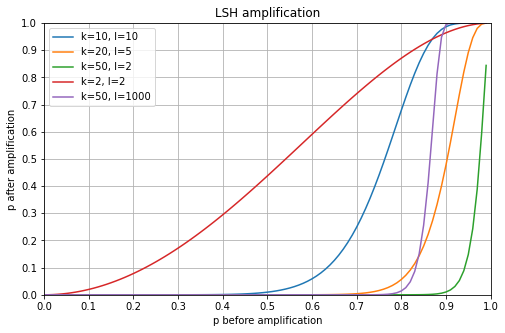

In [15]:
import matplotlib.pyplot as plt

def plotLSH(klpairs,figsize=[8,5]):
    fig, ax = plt.subplots(figsize=figsize)
    P=[x/100 for x in range(100)]
    for k,l in klpairs:
        Probs=[1-(1-(p)**k)**l for p in P]
        ax.plot(P,Probs,label="k="+str(k)+", l="+str(l))
    ax.set_xlabel("p before amplification")
    ax.set_ylabel("p after amplification")
    ax.set_title("LSH amplification")
    Ticks=[x/10 for x in range(11)]
    ax.set_xticks(Ticks)
    ax.set_yticks(Ticks)
    ax.legend()
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.grid()

plotLSH([(10,10),(20,5),(50,2),(2,2),(50,1000)])


In general $\ell$ is more important than $k$ to minimize for reasons I will explain soon. So, here are two functions. One which given a $k$ finds the best $\ell$ to minimize the error. The second function, which uses the first, is given an desired error rate and finds the smallest $k$ 

In [16]:
def findMinK(p1in,p2in,l):
    bestk=-1
    minerror=2
    best=None
    k=1
    while True:
        p1,p2=computeOrOfAndProbabilities(p1in,p2in,k,l)
        e=error(p1,p2)
        if e<=minerror:
            minerror=e
            bestk=k    
            best=(p1,p2)
            k+=1
        else:
            break
    return (bestk,minerror,best)

l=5
p1=.8
p2=.9
bestk,minerror,best=findMinK(p1,p2,l)
print("Best error starting with p1="+str(p1)+" and p2="+str(p2)+" with l="+str(l)+" is k="+str(bestk)+" error="+str(minerror))

Best error starting with p1=0.8 and p2=0.9 with l=5 is k=13 error=0.24627112669033757


In [17]:
def findKL(p1,p2,err):
    l=1
    for x in range(40):
        bestk,minerror,best=findMinK(p1,p2,l)
        if minerror<err:
            return (bestk,l,minerror,best)
        l+=1
        
p1=.6
p2=.8
err=0.1
bestk,bestl,minerror,best=findKL(p1,p2,err)
print("With p1="+str(p1)+" p2="+str(p2)+" and target error>"+str(err)+
      " choose: k="+str(bestk)+" l="+str(bestl)+" kl="+str(bestl*bestk)+" which gives error="+str(minerror))

With p1=0.6 p2=0.8 and target error>0.1 choose: k=11 l=26 kl=286 which gives error=0.09679312516841665


# Back to Jaquard and minhash

Does our score estimator meet the definition of LSH? Yes! Recall the LSH definition:

Suppose you have a set of hash functions $H$, some data, and some distance measure $d$ over your data. We say that $H$ is a $(r,c,p_1,p_2)$ LSH family if:

- If $d(x,y) \leq r$ then $h(x)=h(y)$ with probability at least $p_1$
- If $d(x,y) \geq cr$ then $h(x)=h(y)$ with probability at most $p_2$

with $p_1>p_2$.


Recall that $j(x,y)$ was the Jaquard similarity. As LSH requires a distance, let $d(x,y)=1-j(x,y)$ so that identical strings have distance zero and very different strings have distance 1. For the hash, we simplly use the score as computed from the random permutation of the fragments. We had shown that $Pr[s(x)=s(y)]=j(x,y)$.

Thus we have

- If $\overbrace{d(x,y) \leq r}^{j(x,y) \geq 1-r}$ then $s(x)=s(y)$ with probability at least $1-r$ 
- If $\underbrace{d(x,y) \geq cr}_{j(x,y) \leq 1-cr}$ then $s(x)=s(y)$ with probability at most $1-cr$ 





I will now go though an example, given a real data set, how to use LSH to see if there is a document similar to a query document. First, the following code downloads the data set and may take some time the first time you run it:

In [18]:
import nltk
from nltk.corpus import reuters
nltk.download('reuters')

[nltk_data] Downloading package reuters to /Users/iacono/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

Now, some minor processing. I print the number of documents, the total size, and the 700th document just to show you what they look like. I also put all the documents into a dictionary `data` where each document is indexed by a document ID, which is a short string.

In [19]:
# List of documents
IDs=reuters.fileids()
print("Number of documents:",len(IDs))
print("Total size",sum(len(reuters.raw(IDs[i])) for i in range(len(IDs))))
print(reuters.raw(IDs[700]));

#Put data into dictionary
data={}
for id in IDs:
    data[id]=reuters.raw(id)


Number of documents: 10788
Total size 8846853
SMUGGLING BLAMED FOR CLOSURE OF HAITIAN SUGAR FIRM
  A sugar mill which was this
  nation's second largest employer closed its doors yesterday,
  saying it had been run out of business by sugar smuggled from
  Miami and the neighbouring Dominican Republic.
      The closure of the Haitian American Sugar Company (HASCO)
  will idle 3,500 employees and affect as many as 30,000 to
  40,000 small sugar cane planters in regions around the capital,
  the company said.
      "Because of unprecedented and ever-growing smuggling, HASCO
  regrets ... It cannot continue to accept delivery of sugar cane
  after April 10," the mill warned planters earlier this week.
      Since President Jean-Claude Duvalier fled Haiti fourteen
  months ago, widescale smuggling of basic goods such as cooking
  oil, flour, rice, sugar and canned milk has lowered consumer
  prices but bankrupted several local manufacturers, throwing
  hundreds of thousands of Haitians out

Now, I take the above document and made a few small changes, such as changing the word `CLOSURE` to `OPENING` in the first sentence and add it to the data set with ID `TOTEST`.

In [20]:
TOTEST="""SMUGGLING BLAMED FOR OPENING OF HAITIAN SUGAR FIRM
  A sugar mill which was this
  nation's second largest employer closed its doors yesterday,
  saying it had been run out of business by sugar smuggled from
  Miami and the neighbouring Dominican Republic.
      The closure of the Haitian American Sugar Company (HASCO)
  will idle 3,500 employees and affect as many as 30,000 to
  40,000 small sugar cane planters in regions around the capital,
  the company said.
      "Because of unprecedented and ever-growing smuggling, HASCO
  regrets ... It cannot continue to accept delivery of sugar cane
  after April 10," the mill warned planters earlier this week.
      Since President Jean-Claude Duvalier fled Haiti fourteen
  months ago, widescale smuggling of basic goods such as cooking
  oil, flour, rice, sugar and canned milk has lowered consumer
  prices but bankrupted several local manufacturers, throwing
  hundreds of thousands of Haitians out of work.
      At the HASCO compound, where grim-faced workers lined up to
  receive their last pay, Spokesman Georges D. Rigaud showed a
  warehouse stocked with an estimated 445,000 unsold 100-pound
  (45-kg) bags of sugar.
      "We are closing because of our huge stock of unsold sugar.
  We have no money left to continue operations," Rigaud said.
      He said the company owed 7.6 mln dlrs and had borrowed an
  additional 1.5 mln dlrs in order to pay off workers.
      Rigaud blamed the mill's problems on an order by Duvalier
  two years ago forbidding HASCO from refining sugar.
      He said the government then began importing refined sugar
  at world market prices and reselling it at a huge profit and
  the provisional military-civilian government that replaced
  Duvalier last year continued the policy.
      "But now with all the smuggling even the state can't compete
  with smuggled Dominican refined sugar," Rigaud said.
      HASCO workers earned 4.20 dlrs daily, considerably above
  the usual minimum wage of three dlrs.
      It is generally estimated that every employed Haitian
  supports at least six people. Rigaud said HASCO's closing at a
  minimum would affect 280,000 to 300,000 people.
      Laid-off workers were bitter about the closure. "We're dead,
  and it's the government that's causing us to die," declared
  Lucien Felix, 34, who has five dependents."""

data["TOTEST"]=TOTEST

Now we break each document into fragments, using a fragment size of 8. I print out the fragments of `TOTEST`.

In [21]:
fragSize=8
frags={}
for id in data:
    frags[id]=fragments(data[id],fragSize) 

In [22]:
print(frags["TOTEST"])

{'gest emp', 'aid HASC', 'blems on', ' is gene', 'Since Pr', ' profit ', '  HASCO ', 'l minimu', 'itians o', 'everal l', 'pany sai', 'ith smug', 'anters i', 'er April', 's genera', 'loyed Ha', 'ock of u', '  and it', 'mum wage', ' stocked', 'o pay of', '\n  We ha', ' the gov', '   He sa', 'as many ', 'to die,"', ' the pro', 'ic goods', 'FIRM\n  A', 'e closur', 'age of t', 'aid.\n   ', 'selling ', 'ling it ', 'd market', 'g Domini', 've depen', 'd canned', 'SCO)\n  w', 'several ', ')\n  will', 'r Compan', 's the go', 'closed i', 't to con', 'dead,\n  ', ' but ban', 'ilitary-', 'i fourte', 'prices a', 'usiness ', 'addition', 'dle 3,50', 'd\n  Duva', '4.20 dlr', 'est empl', 'of the H', 'ers were', 'egrets .', 'ee dlrs.', '0 to 300', "'s causi", '    It i', 'nnot con', ' the usu', 'ugar can', 'yesterda', 'r\n  two ', ' now wit', 'k has lo', 'th smugg', 'e depend', ' causing', 's D. Rig', 'ugar.\n  ', 'ted 445,', 'rder by ', 'derably ', 'losure. ', 'ier last', 'the comp', 'ing\n  hu', 'mill

Now we compute the scores for each fragment. To keep things simple, I choose $h$ and $\ell$ to both be 2, and thus need four scores. This will take a little time to run, 20 seconds or so on my machine. I print out the scores of `TOTEST`. So at this point each document, no matter how long, has be transformed into 4 numbers.

In [23]:
h=2
l=2
scores=multipleScoreDict(frags,h*l)

In [24]:
print(scores["TOTEST"])

[2628, 1380, 420, 74]


Now we build the search structure. In our example with $h$ and $\ell$ being 2 each, given a query document with scores `[s1, s2, s3, s4]` we want to be able to quickly check if there is a document with scores `[t1 t2 t3 t4]` with ($s_1=t_1$ and $s_2=t_2$) or ($s_3=t_3$ and $s_4=t_4$). Let's focus first on checking if $s_1=t_1$ and $s_2=t_2$. This can be done by having a dictionary, call it $d_1$ where we store the tuple $(t_1,t_2)$ as the key and a list of documents having this $(t_1,t_2)$ as the value. Then to answer the first part of the query we just see if $(q_1,q_2)$ is in $d_1$, which takes constant time. We do the same for each of the $\ell$ parts, in this case 2, each with a different dictionary.

Here is the code to create these dictionaries, note we exclude `TOTEST` as we want to search for it, and not have it stored.

In [25]:
SearchStructure=[ {} for i in range(l)]
for id in data:
    if id != "TOTEST":
        for ll in range(l):
            group=tuple(scores[id][ll*h:(ll+1)*h])
            if group not in SearchStructure[ll]:
                SearchStructure[ll][group]=[]
            SearchStructure[ll][group].append(id)


Now here is the code to perform the tests. This is just one lookup in each of the $\ell=2$ dictionaries. We search for the `TOTEST` document and with any luck find the original document, the one with "CLOSURE" in the title, and no others. (When I run it it works, but there is always a chance of failure....) 

I compute the Jaquard similarity as well between the "TOTEST" document and any that are returned. This is a nice way to double check to see if any false positives are returned, and is cheap if there are not many. (I don't get any).

In [26]:
searchResults=set()
for ll in range(l):
    group=tuple(scores["TOTEST"][ll*h:(ll+1)*h])
    if group in SearchStructure[ll]:
        searchResults.update(SearchStructure[ll][group])
print(searchResults)

{'test/16093'}


In [27]:
for result in searchResults:
    print(jaquard(fragments(data[result],8),fragments(data["TOTEST"],8)))
    print(data[result])

0.9848970251716247
SMUGGLING BLAMED FOR CLOSURE OF HAITIAN SUGAR FIRM
  A sugar mill which was this
  nation's second largest employer closed its doors yesterday,
  saying it had been run out of business by sugar smuggled from
  Miami and the neighbouring Dominican Republic.
      The closure of the Haitian American Sugar Company (HASCO)
  will idle 3,500 employees and affect as many as 30,000 to
  40,000 small sugar cane planters in regions around the capital,
  the company said.
      "Because of unprecedented and ever-growing smuggling, HASCO
  regrets ... It cannot continue to accept delivery of sugar cane
  after April 10," the mill warned planters earlier this week.
      Since President Jean-Claude Duvalier fled Haiti fourteen
  months ago, widescale smuggling of basic goods such as cooking
  oil, flour, rice, sugar and canned milk has lowered consumer
  prices but bankrupted several local manufacturers, throwing
  hundreds of thousands of Haitians out of work.
      At the HASC

How fast was this to query? About time linear in the query document to generate the fragments and score, plus only $O(l)$ for the query itself. In our case $l=2$! 

Recall before to query $m$ documents would have taken $O(mnd)$ time, where now only $O(m(l+d))$, which in the typical case where $l \leq d$ is just $O(md)$, which is the time to read in the query documents. This savings of $m$ is the difference between a method which is impractical for large amount of data and one that works quite well.

# Homework

In the last example I included the search string into the data set before the scores were generated. Realistically, however, the flow is usually you do not have the query in advance (and there is usually more than one query). Describe (or better, code!) what changes need to be made if we want to first do all the preprocessing on the data to be searched, and then receive the search strings one at a time. When we receive these search strings we only want to look at a very small amount of the data to be searched.
